In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import turicreate as tc
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy
import implicit
from scipy.sparse import csr_matrix, lil_matrix
from scipy import spatial
from scipy import stats
from sklearn.cluster import KMeans
%matplotlib inline

# CHAPTER 2: Dataset - UK retail transactions (UCI)

This dataset, obtained from UCI is about retail transaction history in the UK and other countries. To continue further, data cleaning and preprocessing is done first, followed by EDA.

In [2]:
data = pd.read_excel("online_retail_II.xlsx")

In [3]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


# CHAPTERS 5, 6 : DATA CLEANING and EXPLORATORY DATA ANALYSIS

Checking for null values:

In [4]:
data.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [5]:
#checking for datatypes of all the attributes of the dataset:
data.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [6]:
#Statistical summary of the attributes of the dataset
data.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [7]:
#Checking how diverse the data set is in terms of Country:
countries = data['Country'].unique()
print("The countries in the retail dataset are:", countries)

The countries in the retail dataset are: ['United Kingdom' 'France' 'USA' 'Belgium' 'Australia' 'EIRE' 'Germany'
 'Portugal' 'Japan' 'Denmark' 'Nigeria' 'Netherlands' 'Poland' 'Spain'
 'Channel Islands' 'Italy' 'Cyprus' 'Greece' 'Norway' 'Austria' 'Sweden'
 'United Arab Emirates' 'Finland' 'Switzerland' 'Unspecified' 'Malta'
 'Bahrain' 'RSA' 'Bermuda' 'Hong Kong' 'Singapore' 'Thailand' 'Israel'
 'Lithuania' 'West Indies' 'Lebanon' 'Korea' 'Brazil' 'Canada' 'Iceland']


In [8]:
#Checking how many distinct products, customers and transactions which are our attributes of interest
products = data['StockCode'].unique()
customers = data['Customer ID'].unique()
transactions = data['Invoice'].unique()
print("Number of products:", len(products))
print("Number of customers:", len(customers))
print("Number of unique/cumulative orders placed:", len(transactions))

Number of products: 4632
Number of customers: 4384
Number of unique/cumulative orders placed: 28816


In [9]:
#No of units sold per product
noOfOrders = data['StockCode'].value_counts()
unitsSold = pd.DataFrame(data = {'Product': noOfOrders.index.values, 'Units Sold': noOfOrders.values})
unitsSold

,Product,Units Sold
0,85123A,3516
1,22423,2221
2,85099B,2057
3,21212,1933
4,21232,1843
...,...,...
4627,90182A,1
4628,85160b,1
4629,47340B,1
4630,85025A,1


In [10]:
#Shopping trends based on Customers
shopaholic = data.groupby('Customer ID')['Quantity'].sum()
frequency = pd.DataFrame(data = {'Customer': shopaholic.index.values, 'Units Bought': shopaholic.values})
frequency.sort_values(by = 'Units Bought', ascending = False)

,Customer,Units Bought
1110,13902.0,218090
1662,14646.0,168501
957,13694.0,123639
4254,18102.0,122988
1291,14156.0,106885
...,...,...
3995,17755.0,-30
2483,15767.0,-50
2611,15935.0,-286
1432,14337.0,-393


Next, we notice that there are some Invoices starting with 'C' and 'A' - Cancelled orders. We analyze them and remove them from our dataset.

In [11]:
#data['Quantity'].agg(lambda x: sum(x < 0)).sum()
cancelled = data['Quantity'].lt(0).sum()
print("Number of Cancelled Transactions:", cancelled)

Number of Cancelled Transactions: 12326


In [12]:
valid = len(data['Quantity']) -  cancelled
print("Number of Valid Transactions:", valid)

Number of Valid Transactions: 513135


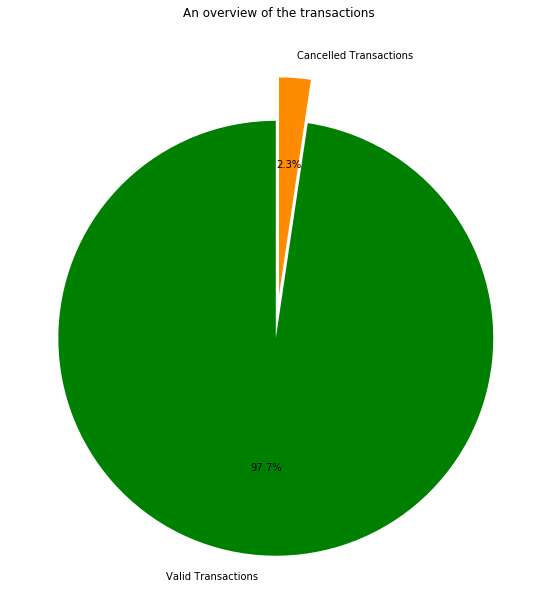

In [13]:
fig, ax = plt.subplots(figsize = (10,10))
explode = (0.2, 0)
#explode1 = (0.05, 0.05)
colors = ['green', 'darkorange']
#colors1 = ['#66b3ff', '#ff9999']
plt.title('An overview of the transactions')
ax.pie([valid, cancelled], explode = explode, colors = colors, labels=(f'Valid Transactions', f'Cancelled Transactions'), startangle=90, autopct='%1.1f%%')
plt.show()

The Negative values from the columns denote the following: 

1. Quantity of the product has been returned
2. Price has been refunded back to the customer
3. Customer has been deleted from the database
4. Invoices starting with A and C are cancelled and adjusted to debt orders

In [14]:
#An overview of the cancelled orders:
print(data[data["Invoice"].astype(str).str[0] == "C"])
print(data[data["Invoice"].astype(str).str[0] == "A"])

        Invoice StockCode                       Description  Quantity  \
178     C489449     22087          PAPER BUNTING WHITE LACE       -12   
179     C489449    85206A      CREAM FELT EASTER EGG BASKET        -6   
180     C489449     21895     POTTING SHED SOW 'N' GROW SET        -4   
181     C489449     21896                POTTING SHED TWINE        -6   
182     C489449     22083        PAPER CHAIN KIT RETRO SPOT       -12   
...         ...       ...                               ...       ...   
524695  C538123     22956          36 FOIL HEART CAKE CASES        -2   
524696  C538124         M                            Manual        -4   
524697  C538124     22699  ROSES REGENCY TEACUP AND SAUCER         -1   
524698  C538124     22423          REGENCY CAKESTAND 3 TIER        -1   
525282  C538164    35004B       SET OF 3 BLACK FLYING DUCKS        -1   

               InvoiceDate  Price  Customer ID         Country  
178    2009-12-01 10:33:00   2.95      16321.0       Austr

We check for null values and remove the above said negative values.

In [15]:
#data.drop(data['Quantity'] <= 0)
print(data.shape)
data = data[data["Quantity"] > 0 ]
data = data[data["Price"] >= 0 ]
data = data[data["Customer ID"] >= 0 ]


#All entries with entries starting with C in Invoice column had negative values. 
data = data[data["Invoice"].astype(str).str[0] != "C"]
data = data[data["Invoice"].astype(str).str[0] != "A"]
print(data.shape)

#Calculating Revenue 
data['Revenue'] = data['Price'] * data['Quantity']
data.head()

(525461, 8)
(407695, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [16]:
#Checking for null values after data preprocessing:
data.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Revenue        0
dtype: int64

In [17]:
#Splitting the DateTime object to date, month, year, weekday, day for analysis
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Date'] = data['InvoiceDate'].dt.date
data['Day'] = data['InvoiceDate'].dt.day
data['Weekday'] = data['InvoiceDate'].dt.dayofweek

In [18]:
#Summary of cleaned data

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407695 entries, 0 to 525460
Data columns (total 14 columns):
Invoice        407695 non-null object
StockCode      407695 non-null object
Description    407695 non-null object
Quantity       407695 non-null int64
InvoiceDate    407695 non-null datetime64[ns]
Price          407695 non-null float64
Customer ID    407695 non-null float64
Country        407695 non-null object
Revenue        407695 non-null float64
Year           407695 non-null int64
Month          407695 non-null int64
Date           407695 non-null object
Day            407695 non-null int64
Weekday        407695 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(5), object(5)
memory usage: 46.7+ MB


To check how diverse the data is, we check the plot of Number of orders placed country wise.

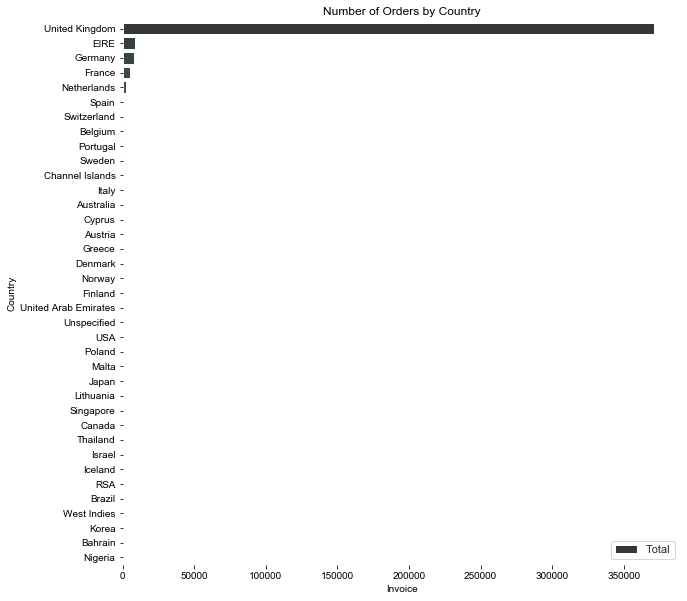

In [19]:
orders_by_country = data.groupby('Country')['Invoice'].count().sort_values(ascending=False)
index = orders_by_country.index
temp = pd.DataFrame(orders_by_country)

f, ax = plt.subplots(figsize=(10, 10))
#sns.set_color_codes("pastel")
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x="Invoice", y=temp.index, data=temp, label="Total", palette = 'GnBu_d').set_title('Number of Orders by Country')
ax.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)

Clearly, UK occupies the most and is an outlier and hence, we remove it and check the plot again:

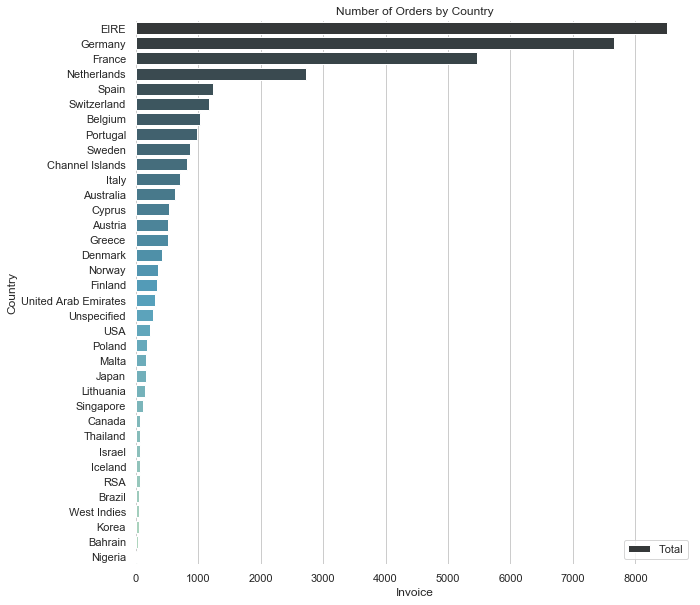

In [20]:
orders_by_country = data.groupby('Country')['Invoice'].count().sort_values(ascending=False)
del orders_by_country['United Kingdom']
index = orders_by_country.index
temp = pd.DataFrame(orders_by_country)

f, ax = plt.subplots(figsize=(10, 10))
#sns.set_color_codes("pastel")
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x="Invoice", y=temp.index, data=temp, label="Total", palette = 'GnBu_d').set_title('Number of Orders by Country')
ax.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)

To check the desity of our data, we check the plot of Revenue spent country wise.

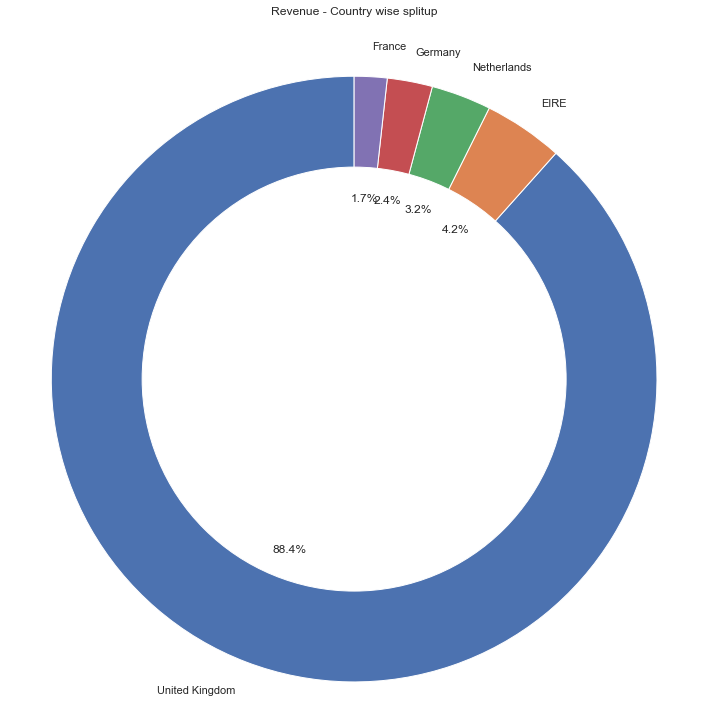

In [21]:
country_revenue = data.groupby('Country')['Revenue'].sum()
percentage = ((country_revenue/country_revenue.sum())*100).round(2)
percentage = percentage.sort_values(ascending = False)
percentage = percentage[0:5]
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Revenue - Country wise splitup', y = 1.05)
ax.pie(percentage, labels=percentage.index, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal') 
plt.tight_layout()
plt.show()

To check the desity of our data, we check the plot of Average Revenue spent country wise.

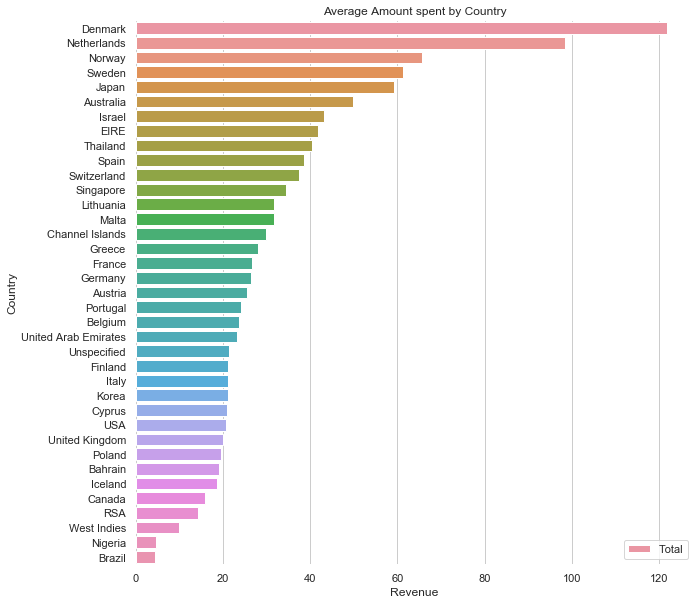

In [22]:
amount_by_country = data.groupby('Country')['Revenue'].mean().sort_values(ascending=False)
index = amount_by_country.index
temp = pd.DataFrame(amount_by_country)

f, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x="Revenue", y=temp.index, data=temp,label="Total").set_title('Average Amount spent by Country')
ax.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)

Though UK has the highest revenue, the number of orders are way too huge than the others. Hence, interestingly, UK went down when the average amount spent by country was calculated.

Next, we check when was the time when the highest nunber of orders were placed online in terms of months.

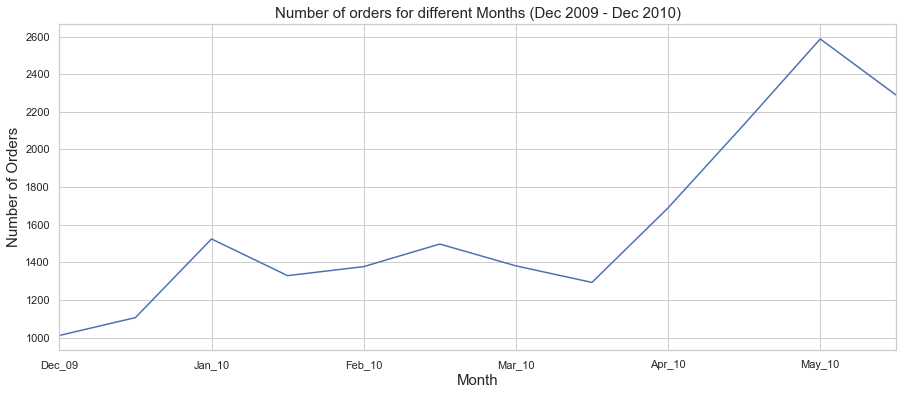

In [23]:
ax = data.groupby('Invoice')['Month'].unique().value_counts().sort_index().plot(figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (Dec 2009 - Dec 2010)',fontsize=15)
ax.set_xticklabels(('Dec_09','Jan_10','Feb_10','Mar_10','Apr_10','May_10','Jun_10','July_10','Aug_10','Sep_10','Oct_10','Nov_10','Dec_10'), rotation='horizontal')
plt.show()

The peak is in the month of May, 2010 and the least was in the month of December, 2009. 

Likewise, we check when was the time when the highest nunber of orders were placed online in terms of Weekdays.

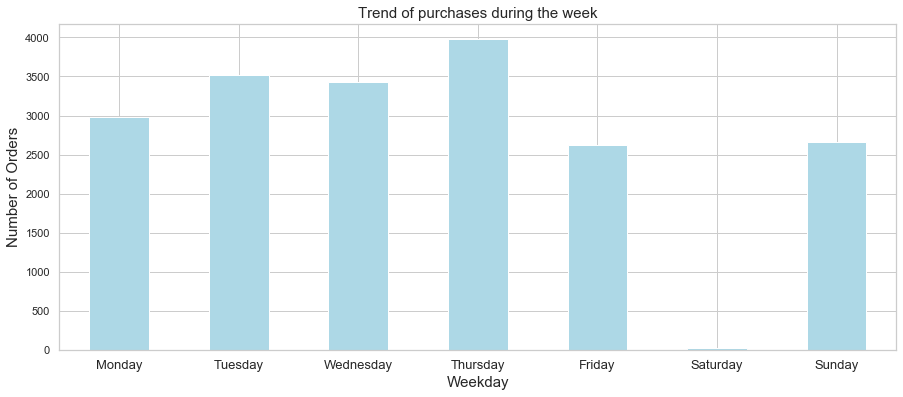

In [24]:
ax = data.groupby('Invoice')['Weekday'].unique().value_counts().sort_index().plot(kind = 'bar', figsize=(15,6), color = 'lightblue')
ax.set_xlabel('Weekday',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Trend of purchases during the week',fontsize=15)
ax.set_xticklabels(('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), rotation='horizontal',  fontsize=13)
plt.show()

Interestingly, many orders were placed in the weekdays than on the weekends, especially Saturday.

# CHAPTER 7: COLLABORATIVE RECOMMENDER

We filter out the Customer ID, the product and it's description along with how many times the user bought that product

In [25]:
filtered = data.groupby(['Customer ID','StockCode','Description'], as_index = False).agg({'Invoice': 'nunique'})
filtered.rename(columns = {'Invoice': 'NoOfPurchases'}, inplace = True)
filtered

,Customer ID,StockCode,Description,NoOfPurchases
0,12346.0,20679,EDWARDIAN PARASOL RED,1
1,12346.0,20682,RED SPOTTY CHILDS UMBRELLA,1
2,12346.0,20685,DOORMAT RED SPOT,1
3,12346.0,21523,DOORMAT FANCY FONT HOME SWEET HOME,1
4,12346.0,21524,DOORMAT SPOTTY HOME SWEET HOME,1
...,...,...,...,...
280774,18287.0,85040A,S/4 PINK FLOWER CANDLES IN BOWL,2
280775,18287.0,85040B,SET/4 BLUE FLOWER CANDLES IN BOWL,1
280776,18287.0,85199S,SMALL HANGING IVORY/RED WOOD BIRD,1
280777,18287.0,85232B,SET/3 RUSSIAN DOLL STACKING TINS,1


Next, we create a sparse matrix with the attributes of our interest: 'CusotmerID (user)' and 'StockCode (item)'

In [26]:
#Converting the columns Customer ID and Stock Code to categories to get the unique values and group data accordingly
filtered['Customer ID'] = filtered['Customer ID'].astype("category")
filtered['StockCode'] = filtered['StockCode'].astype("category")

#Retriving the index/code of the categegories and setting them to user and item columns
filtered['user'] = filtered['Customer ID'].cat.codes
filtered['item'] = filtered['StockCode'].cat.codes
filtered

,Customer ID,StockCode,Description,NoOfPurchases,user,item
0,12346.0,20679,EDWARDIAN PARASOL RED,1,0,94
1,12346.0,20682,RED SPOTTY CHILDS UMBRELLA,1,0,97
2,12346.0,20685,DOORMAT RED SPOT,1,0,100
3,12346.0,21523,DOORMAT FANCY FONT HOME SWEET HOME,1,0,741
4,12346.0,21524,DOORMAT SPOTTY HOME SWEET HOME,1,0,742
...,...,...,...,...,...,...
280774,18287.0,85040A,S/4 PINK FLOWER CANDLES IN BOWL,2,4313,3597
280775,18287.0,85040B,SET/4 BLUE FLOWER CANDLES IN BOWL,1,4313,3598
280776,18287.0,85199S,SMALL HANGING IVORY/RED WOOD BIRD,1,4313,3697
280777,18287.0,85232B,SET/3 RUSSIAN DOLL STACKING TINS,1,4313,3716


To build a recommender, we need to construct two matrices:

1. Product/Item - Customer/User matrix for holding the data and to train and fit the model.
2. Customer/User - Product/Item matrix to give recommendations from the model built above.

We build a Compressed Sparse Matrix to achieve the above:

In [27]:
ItemUser = scipy.sparse.csr_matrix((filtered['NoOfPurchases'].astype(float), (filtered['item'], filtered['user'])))
UserItem = scipy.sparse.csr_matrix((filtered['NoOfPurchases'].astype(float), (filtered['user'], filtered['item'])))

In [28]:
ItemUser

<4017x4314 sparse matrix of type '<class 'numpy.float64'>'
	with 274449 stored elements in Compressed Sparse Row format>

In [29]:
UserItem

<4314x4017 sparse matrix of type '<class 'numpy.float64'>'
	with 274449 stored elements in Compressed Sparse Row format>

Since this is an implicit variety of data, i.e., no ratings have been provided by the users to the items to determine the likeability of the product. But we have the number of times the user bought the products. Hence, we can use that as an implicit method to recommed products for the user.

To implement this, we factorize the matrix by using Alternative Least Squares which scales very large datasets.

In [30]:
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
confidence = (ItemUser * alpha).astype('double')

model.fit(confidence)


A customized function to retrive the user's purchase history and the relative recommendations from the model:

In [31]:
def purchased(user):
    return pd.DataFrame(filtered[filtered['user'] == user]['Description'].unique())

def description(items):
    descriptions = []
    for item in items:
        descriptions.extend(filtered[filtered['item'] == item ]['Description'].unique())
    descriptions = pd.DataFrame(descriptions)
    return descriptions

def recommendations(user):
    itemRecs = {}
    recommended = model.recommend(user, UserItem)
    for item in recommended:
        #print(item[1])
        itemRecs[item[0]] = item[1]  
    return itemRecs

Recommendations for the user '100':

In [32]:
print("Items purchased by user:", purchased(100))
print("\nRecomendations for this user:", description(recommendations(100).keys()))

Items purchased by user:                                 0
0  SET OF MEADOW  FLOWER STICKERS
1   RED TOADSTOOL LED NIGHT LIGHT

Recomendations for this user:                                       0
0                               POSTAGE
1   ROUND SNACK BOXES SET OF4 WOODLAND 
2    ROUND SNACK BOXES ,SET4, WOODLAND 
3     STRAWBERRY LUNCH BOX WITH CUTLERY
4      STRAWBERRY LUNCHBOX WITH CUTLERY
5        DINOSAUR LUNCHBOX WITH CUTLERY
6       DINOSAUR LUNCH BOX WITH CUTLERY
7     LUNCH BOX WITH CUTLERY RETROSPOT 
8      LUNCHBOX WITH CUTLERY RETROSPOT 
9                   TOADSTOOL MONEY BOX
10           RED SPOTTY CHILDS UMBRELLA
11     RED RETROSPOT CHILDRENS UMBRELLA
12    ROUND SNACK BOXES SET OF 4 SKULLS
13     SET/3 RUSSIAN DOLL STACKING TINS
14      SET OF 3 BABUSHKA STACKING TINS
15  LUNCH BOX WITH CUTLERY FAIRY CAKES 
16   LUNCHBOX WITH CUTLERY FAIRY CAKES 


# CHAPTER - 8 : CUSTOMER SEGMENTATION

# RFM ANALYSIS

Retrieving the most recent date of the dataset:

In [33]:
last_timestamp = data['InvoiceDate'].max()
last_date = last_timestamp.date()
last_date

datetime.date(2010, 12, 9)

In [34]:
data['date'] = pd.DatetimeIndex(data['InvoiceDate']).date
data.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,Year,Month,Date,Day,Weekday,date
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,2009-12-01,1,1,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,2009-12-01,1,1,2009-12-01


## Recency (R) 

Since customers have bought many orders, we have to extract the most recent one.

In [35]:
recent = data.groupby(by = 'Customer ID', as_index = False)['date'].max()
recent.head(5)

,Customer ID,date
0,12346.0,2010-06-28
1,12347.0,2010-12-07
2,12348.0,2010-09-27
3,12349.0,2010-10-28
4,12351.0,2010-11-29


In [36]:
recent['GapOfDays'] = last_date - recent['date']
recent['Recency'] = recent['date'].apply(lambda x: (last_date - x).days)
recent.head(5)

,Customer ID,date,GapOfDays,Recency
0,12346.0,2010-06-28,164 days,164
1,12347.0,2010-12-07,2 days,2
2,12348.0,2010-09-27,73 days,73
3,12349.0,2010-10-28,42 days,42
4,12351.0,2010-11-29,10 days,10


## Frequency (F)

Grouping all the orders to see how many orders were placed from the beginning of time.

In [37]:
frequent = data.groupby(by = 'Customer ID', as_index = False)['Invoice'].count()
frequent.columns = ['Customer ID', 'Frequency']
frequent.head(5)

,Customer ID,Frequency
0,12346.0,33
1,12347.0,71
2,12348.0,20
3,12349.0,102
4,12351.0,21


## Monetary (M) 

Calculating the sum of money spent on all orders by every customer:

In [38]:
monetary = data.groupby(by = 'Customer ID', as_index = False)['Revenue'].sum()
monetary.columns = ['Customer ID', 'Monetary']
monetary.head(5)

,Customer ID,Monetary
0,12346.0,372.86
1,12347.0,1323.32
2,12348.0,222.16
3,12349.0,2671.14
4,12351.0,300.93


## RFM  

In [39]:
#Merging all the scores:
temp = recent.merge(frequent, on ='Customer ID')
RFM = temp.merge(monetary, on = 'Customer ID')
RFM = RFM.set_index('Customer ID')
RFM.head(5)

,date,GapOfDays,Recency,Frequency,Monetary
Customer ID,,,,,
12346.0,2010-06-28,164 days,164,33,372.86
12347.0,2010-12-07,2 days,2,71,1323.32
12348.0,2010-09-27,73 days,73,20,222.16
12349.0,2010-10-28,42 days,42,102,2671.14
12351.0,2010-11-29,10 days,10,21,300.93


Calculating quantile scores by splitting all the scores into 5 quantiles:

In [40]:
rfm_quantiles = RFM.quantile(q=[0.2,0.4,0.6,0.8])
print(rfm_quantiles)
rfm_quantiles.to_dict()

     Recency  Frequency  Monetary
0.2     14.0       15.0   252.172
0.4     35.0       32.0   505.966
0.6     70.0       61.0   991.432
0.8    175.0      127.0  2145.588


{'Recency': {0.2: 14.0, 0.4: 35.0, 0.6: 70.0, 0.8: 175.0},
 'Frequency': {0.2: 15.0, 0.4: 32.0, 0.6: 61.0, 0.8: 127.0},
 'Monetary': {0.2: 252.172,
  0.4: 505.966,
  0.6: 991.4319999999994,
  0.8: 2145.5880000000006}}

Function to determine scores from 1-5 based on the quantiles formed above:

In [41]:
def Recency_Score(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1

def Frequency_Monetary_Score(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5

In [42]:
RFM_results = RFM
RFM_results['R_Quartile'] = RFM_results['Recency'].apply(Recency_Score, args=('Recency', rfm_quantiles))
RFM_results['F_Quartile'] = RFM_results['Frequency'].apply(Frequency_Monetary_Score, args=('Frequency', rfm_quantiles))
RFM_results['M_Quartile'] = RFM_results['Monetary'].apply(Frequency_Monetary_Score, args=('Monetary', rfm_quantiles))
RFM_results.head(5)

,date,GapOfDays,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
Customer ID,,,,,,,,
12346.0,2010-06-28,164 days,164,33,372.86,2,3,2
12347.0,2010-12-07,2 days,2,71,1323.32,5,4,4
12348.0,2010-09-27,73 days,73,20,222.16,2,2,1
12349.0,2010-10-28,42 days,42,102,2671.14,3,4,5
12351.0,2010-11-29,10 days,10,21,300.93,5,2,2


RFM Cumulative Score for each customer is calculated by concatenating all the individual scores.

In [43]:
RFM_results['RFMScore'] = RFM_results.R_Quartile.map(str) \
                            + RFM_results.F_Quartile.map(str) \
                            + RFM_results.M_Quartile.map(str)
RFM_results.head()

,date,GapOfDays,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
Customer ID,,,,,,,,,
12346.0,2010-06-28,164 days,164,33,372.86,2,3,2,232
12347.0,2010-12-07,2 days,2,71,1323.32,5,4,4,544
12348.0,2010-09-27,73 days,73,20,222.16,2,2,1,221
12349.0,2010-10-28,42 days,42,102,2671.14,3,4,5,345
12351.0,2010-11-29,10 days,10,21,300.93,5,2,2,522


In [44]:
#RFM_results.sort_values('Recency').head(10)

In [45]:
#Calculating the sum of R,F,M scores:
RFM_results['Total'] = RFM_results['R_Quartile'] + RFM_results['F_Quartile'] + RFM_results['M_Quartile']
RFM_results.head()

,date,GapOfDays,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total
Customer ID,,,,,,,,,,
12346.0,2010-06-28,164 days,164,33,372.86,2,3,2,232,7
12347.0,2010-12-07,2 days,2,71,1323.32,5,4,4,544,13
12348.0,2010-09-27,73 days,73,20,222.16,2,2,1,221,5
12349.0,2010-10-28,42 days,42,102,2671.14,3,4,5,345,12
12351.0,2010-11-29,10 days,10,21,300.93,5,2,2,522,9


A Mapping Function to segment the customers based on the RFM score. 10 categories: (5 quantiles x 2 variables)

In [46]:
segmentation = {
    r'[1-2][1-2]': 'Inactive',
    r'3[1-2]': 'About to be Inactive ',
    r'[1-2][3-4]': 'At risk of being Inactive',
    r'[3-4][4-5]': 'Satisfied Customers',
    r'[4-5][2-3]': 'Potential Satified Customers',
    r'33': 'Need Attention',
    r'41': 'New - need attention',
    r'51': 'Newbies',
    r'5[4-5]': 'Best customers',
    r'[1-2]5': 'Important - about to be Lost'}

RFM_results['Segment'] = RFM_results['R_Quartile'].map(str) + RFM_results['F_Quartile'].map(str)
RFM_results['Segment'] = RFM_results['Segment'].replace(segmentation, regex=True)

RFM_results.head()

,date,GapOfDays,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total,Segment
Customer ID,,,,,,,,,,,
12346.0,2010-06-28,164 days,164,33,372.86,2,3,2,232,7,At risk of being Inactive
12347.0,2010-12-07,2 days,2,71,1323.32,5,4,4,544,13,Best customers
12348.0,2010-09-27,73 days,73,20,222.16,2,2,1,221,5,Inactive
12349.0,2010-10-28,42 days,42,102,2671.14,3,4,5,345,12,Satisfied Customers
12351.0,2010-11-29,10 days,10,21,300.93,5,2,2,522,9,Potential Satified Customers


In [47]:
segmentation = pd.DataFrame(RFM_results['Segment'].value_counts())

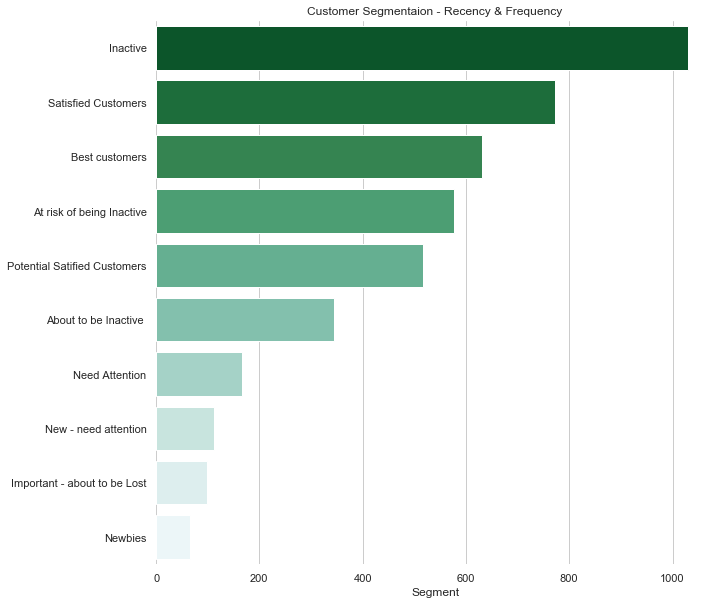

In [48]:
#Plot to visualize the segments of customers
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Segment', y = segmentation.index, data=segmentation, palette = 'BuGn_r').set_title('Customer Segmentaion - Recency & Frequency')
sns.despine(left=True, bottom=True)

In [49]:
#Monetary score analysis

big_spenders = len(RFM_results[RFM_results['M_Quartile']==5])
monetary = pd.DataFrame()
monetary['Category'] = ['Big Spenders', 'Low value but Frequent', 'Lost Low Value Customers', 'Mid-range']
monetary['Count'] = [len(RFM_results[RFM_results['M_Quartile']==5]), (len(RFM_results[RFM_results['RFMScore']=='441']) + 
                     len(RFM_results[RFM_results['RFMScore']=='541']) + len(RFM_results[RFM_results['RFMScore']=='451'])), 
                     len(RFM_results[RFM_results['RFMScore']=='111']), (len(RFM_results[RFM_results['RFMScore']=='333'])+
                     len(RFM_results[RFM_results['RFMScore']=='433']) + len(RFM_results[RFM_results['RFMScore']=='533']) + 
                     len(RFM_results[RFM_results['RFMScore']=='343']) + len(RFM_results[RFM_results['RFMScore']=='353']))]                                  

monetary

,Category,Count
0,Big Spenders,863
1,Low value but Frequent,4
2,Lost Low Value Customers,260
3,Mid-range,273


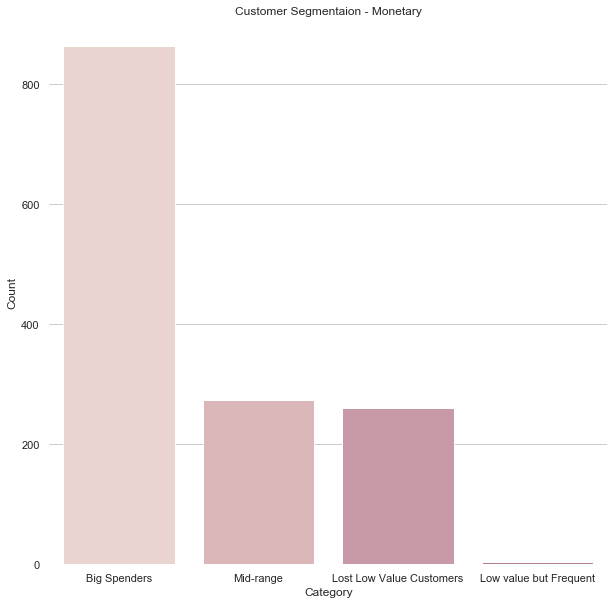

In [50]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Category', y = 'Count', data=monetary.sort_values(by = 'Count', ascending = False), palette = sns.cubehelix_palette(8)).set_title('Customer Segmentaion - Monetary')
sns.despine(left=True, bottom=True)